In [206]:
import datetime
import copy

import numpy as np
import matplotlib.pyplot as plt

In [207]:
t = np.arange(0, 10, 0.001)
u = np.sin(t) + np.random.randn(t.size)/10.0
u[5000:5010] = 1.0
y_iir = copy.copy(u)
y_fir = copy.copy(u)
y_mmf = copy.copy(u)
k = 0.1
n = 99
m = 99
for i in range(t.size):
    if i < 1:
        y_iir[i] = 0
        continue
    y_iir[i] = y_iir[i-1] + 0.01*(u[i] - y_iir[i-1])
for i in range(t.size):
    if i < n:
        y_fir[i] = 0
        continue
    y_fir[i] = np.mean(u[i-n:i])
for i in range(t.size):
    if i < m:
        y_mmf[i] = 0
        continue
    y_mmf[i] = np.median(u[i-m:i])

/tmp/ipykernel_346251/210949591.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(figure.axes[0].get_xticklabels(), fontsize=8)
/tmp/ipykernel_346251/210949591.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(figure.axes[0].get_yticklabels(), fontsize=8)


Text(0.5, 1.0, 'Rejection of Obtuse Values with Naive Filters')

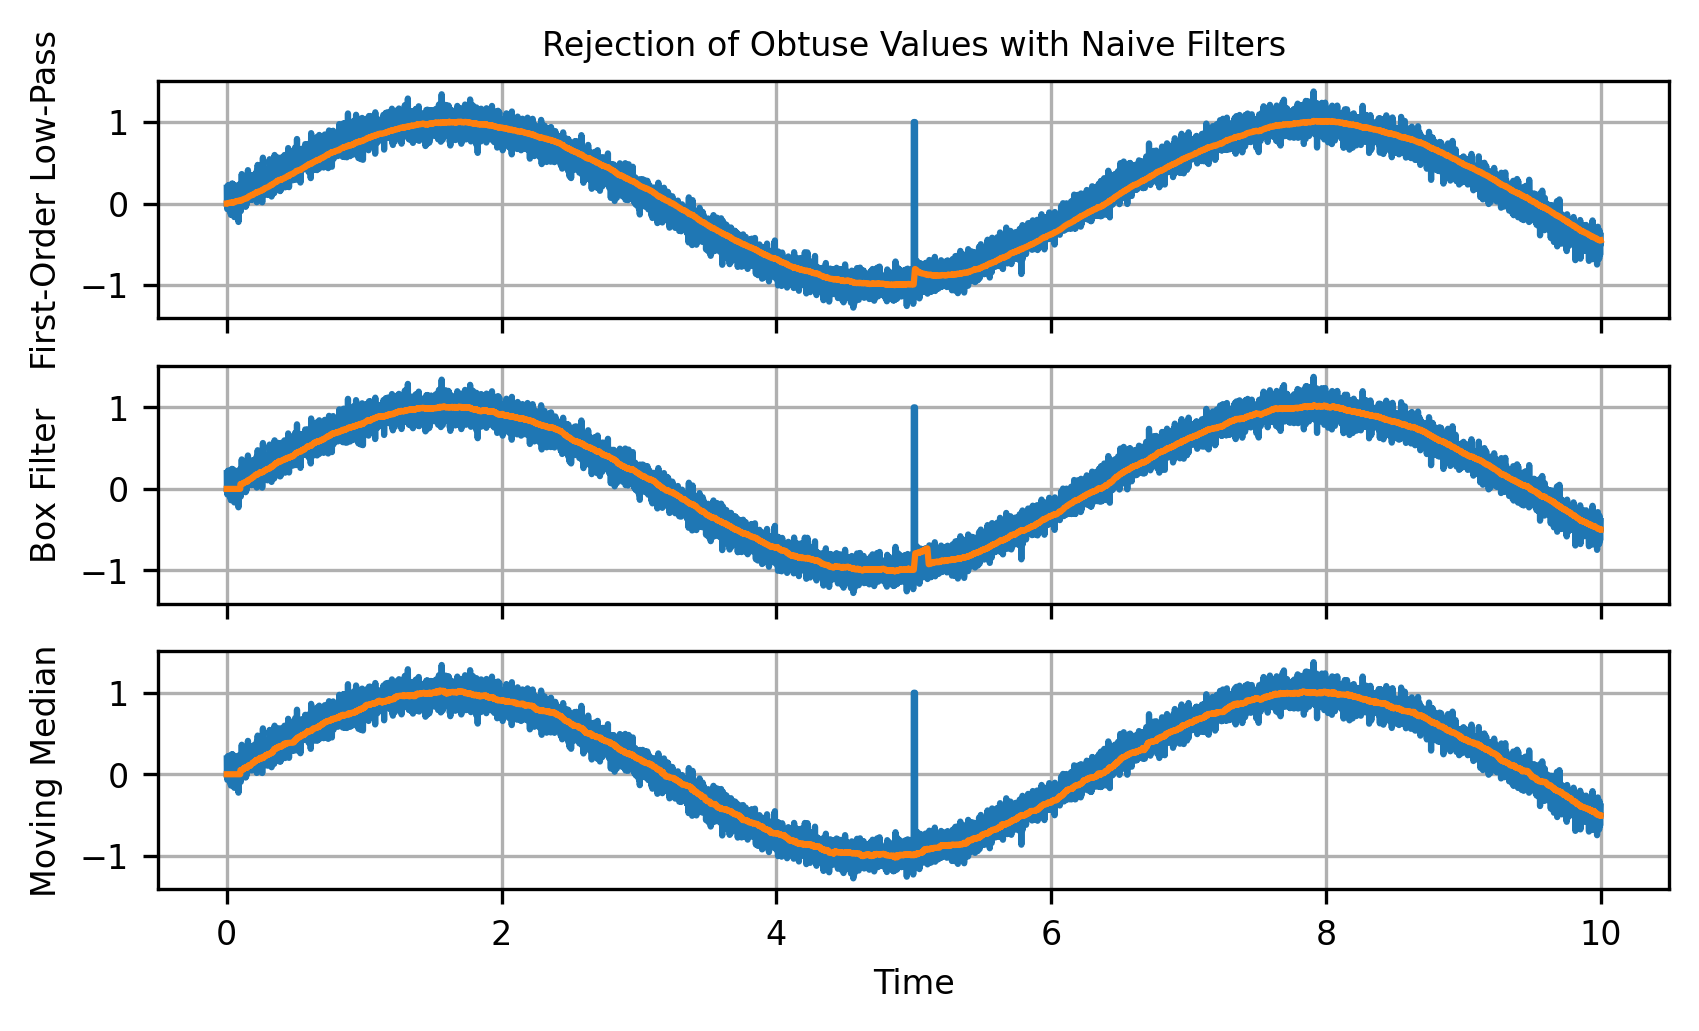

In [212]:
plt.rcParams.update({'font.size': 8})

figure = plt.subplots(nrows=3, ncols=1, figsize=[6.5, 3.5], dpi=300)[0]

figure.axes[0].plot(t, u)
figure.axes[0].plot(t, y_iir)

figure.axes[1].plot(t, u)
figure.axes[1].plot(t, y_fir)

figure.axes[2].plot(t, u)
figure.axes[2].plot(t, y_mmf)

figure.axes[0].grid('on')
figure.axes[1].grid('on')
figure.axes[2].grid('on')

figure.axes[0].set_ylabel('First-Order Low-Pass', fontsize=8)
figure.axes[1].set_ylabel('Box Filter', fontsize=8)
figure.axes[2].set_ylabel('Moving Median', fontsize=8)

figure.axes[2].set_xlabel('Time', fontsize=8)
for ax in figure.axes:
    ax.set_xticklabels(figure.axes[0].get_xticklabels(), fontsize=8)
    ax.set_yticklabels(figure.axes[0].get_yticklabels(), fontsize=8)
for ax in figure.axes[0:-1]:
    ax.set_xticklabels([])

figure.axes[0].set_title('Rejection of Obtuse Values with Naive Filters', fontsize=8)

In [71]:
import sortedcontainers as sc

class MovingMedianBase0():
        
    def __init__(self, n):
        self.sorted_order = sc.SortedList([0]*n) # O(log(n)) container
        self.time_order = [0]*n
        self.mid = int(n/2)

    def update(self, u):
        self.sorted_order.remove(self.time_order.pop(0)) # O(log(n))
        self.time_order.append(u) # O(1)
        self.sorted_order.add(u) # O(log(n))
        return self.median #  # O(log(n)) (but could be O(1)

    @property
    def median(self):
        pass

class MovingMedianOdd0(MovingMedianBase0):

    @property
    def median(self):
        return self.sorted_order[self.mid]

class MovingMedianEven0(MovingMedianBase0):

    @property
    def median(self):
        return (
                self.sorted_order[self.mid - 1] + self.sorted_order[self.mid]
            )/2

class MovingMedian0():

    def __new__(cls, n):
        if n%2 > 0:
            return MovingMedianOdd0(n)
        else:
            return MovingMedianEven0(n)

In [165]:
datetime.datetime.now().timestamp()

1672885817.170028

9008.216857910156


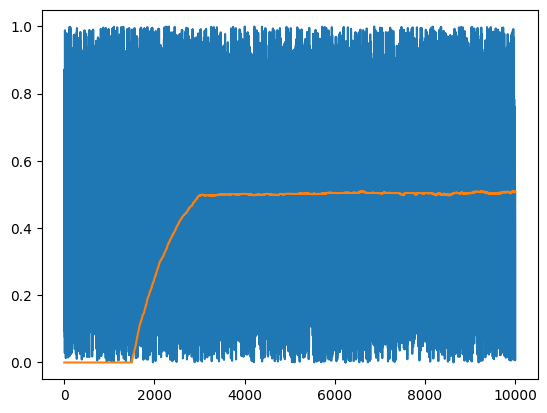

In [166]:
m = 10000
u = np.random.random(m)
y = np.zeros(m)
mm = MovingMedian0(3001)
t = datetime.datetime.now().timestamp()
for i in range(m):
    y[i] = mm.update(u[i])
print((datetime.datetime.now().timestamp() - t)/m*1e9)
plt.plot(u)
plt.plot(y)

In [157]:
import sortedcontainers as sc

class MovingMedianBase():
        
    def __init__(self, n):
        self.lo = sc.SortedList([0]*(n - int(n/2))) # O(log(n)) container
        self.hi = sc.SortedList([0]*int(n/2)) # O(log(n)) container
        self.time_order = [0]*n # List here... just need a queue

    def update(self, u):
        o = self.time_order.pop(0)
        self.time_order.append(u) # O(1)
        
        if o != u: # Don't do anything if o ==u
            if o >= self.hi[0]: # o is in hi
                self.hi.remove(o)
                if u > self.lo[-1]: # u should go in hi
                    self.hi.add(u)
                else: # u in lo
                    self.hi.add(self.lo[-1])
                    self.lo.remove(self.lo[-1])
                    self.lo.add(u)
            else: # o is in lo (it better be)
                self.lo.remove(o)
                if u < self.hi[0]: # u should go in lo
                    self.lo.add(u)
                else: # u should go in hi
                    self.lo.add(self.hi[0])
                    self.hi.remove(self.hi[0])
                    self.hi.add(u)

        return self.median

    @property
    def median(self):
        pass
    
class MovingMedianOdd(MovingMedianBase):

    @property
    def median(self):
        return self.lo[-1] # Median in lo for odd

class MovingMedianEven(MovingMedianBase):

    @property
    def median(self):
        return (self.lo[-1] + self.hi[0])/2

class MovingMedian():

    def __new__(cls, n):
        if n%2 > 0:
            return MovingMedianOdd(n)
        else:
            return MovingMedianEven(n)

15828.895568847656
0.0


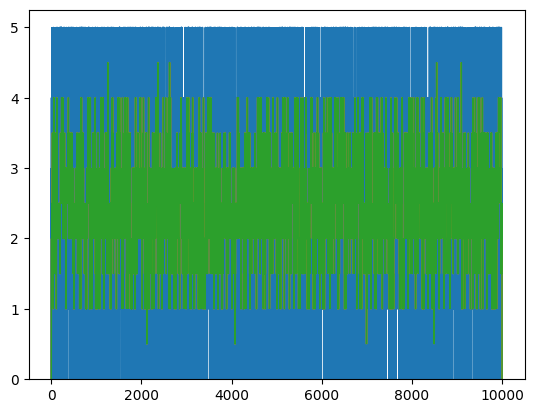

In [198]:
m = 10000
n = 10
u = np.round(np.random.random(m)*5).astype(np.int8)
# u = np.random.random(m)
y = np.zeros(m)
y0 = np.zeros(m)
mm = MovingMedian(n)
mm0 = MovingMedian0(n)
t = datetime.datetime.now().timestamp()
for i in range(m):
    y[i] = mm.update(u[i])
    y0[i] = mm0.update(u[i])
print((datetime.datetime.now().timestamp() - t)/m*1e9)
plt.stairs(u)
plt.stairs(y)
plt.stairs(y0)
print(np.sum(np.abs(y-y0)))

2.326409816741943e-06
4.61669921875e-06
6.940500736236572e-06
9.517920017242432e-06
1.1878709793090821e-05
1.4462440013885498e-05
1.7090299129486084e-05
1.961488962173462e-05
2.2654809951782225e-05
2.550179958343506e-05
2.8152360916137695e-05
3.115427970886231e-05
3.428051948547363e-05
3.7466120719909665e-05
4.116420984268189e-05
4.495616912841797e-05
4.946458101272583e-05
5.417640924453735e-05
5.999650955200195e-05
0.0005154156374931336


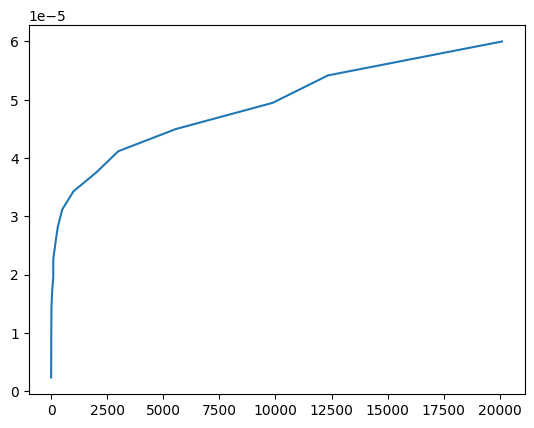

In [199]:
m = 100000
n = 11
u = np.round(np.random.random(m)*5).astype(np.int8)
# u = np.random.random(m)

y = np.zeros(m)
mm = MovingMedian(n)
t = datetime.datetime.now().timestamp()
nn = [5, 7, 9, 10, 15, 20, 50, 99, 100, 200, 301, 500, 1000, 2001, 3000, 5555, 9876, 12345, 20101]
tt = []
for n in nn:
    mm = MovingMedian(n)
    for i in range(m):
        y[i] = mm.update(u[i])
    tt.append((datetime.datetime.now().timestamp() - t)/m)
    print(tt[-1])

print(np.sum(tt))
plt.plot(nn, tt)

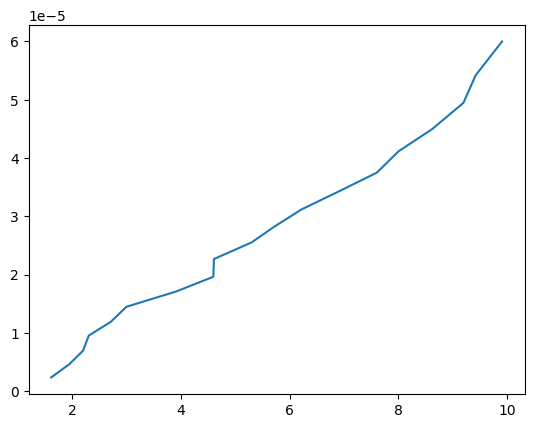

In [200]:
plt.plot(np.log(nn), tt)

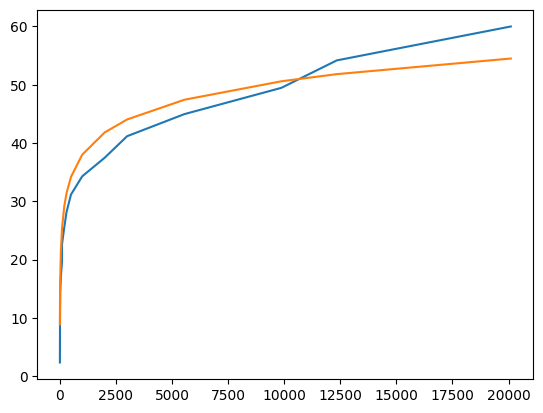

In [205]:
plt.plot(nn, np.array(tt)*1e6)
plt.plot(nn, 5.5*np.log(nn))